# Constructing and testing quant factors                                                 

Concepts

## Fama-French, HML                                                                                           
                                                                                                             
## weekly reversal, quant quake                                                                               
                                                                                                             
References:                                                                                                  
                                                                                                             
https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html                                    
                                                                                                             
Khandani and Lo (2008), “What Happened to the Quants in August 2007?"

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
from pprint import pprint
import dives
from dives.util import fractiles, DataFrame
from dives.dbengines import SQL, Redis
from dives.structured import BusDates, Benchmarks, CRSP, PSTAT
from dives.evaluate import BackTest

import secret    # passwords etc                                                                             
sql = SQL(**secret.value('sql'))
rdb = Redis(**secret.value('redis'))
bd = BusDates(sql)
bench = Benchmarks(sql, bd)
backtest = BackTest(sql, bench, 'RF')
crsp = CRSP(sql, bd, rdb)
pstat = PSTAT(sql, bd)

### Weekly reversal strategy

In [3]:
    crsp.rdb = None      # do not use redis cache                                                            
    tic = time.time()
    holdings = {}                                                             
    rebalbeg, rebalend = 20060701, 20080831
    for weeknum in bd.week_range(rebalbeg, rebalend):
        pordate = bd.week_end(weeknum)              # rebalance date                                         
        beg = bd.shift(bd.week_beg(weeknum), -1)    # date prior to period for measuring past return         
        start = bd.week_beg(weeknum)                # first day of period to measure past return             
        end = bd.week_beg(weeknum)                  # last day of period to measure past return              

        df = crsp.get_universe(pordate)             # generate new universe every week: common domestic      
        df['beg'] = crsp.get_section('daily', ['prc'], 'date', beg).reindex(df.index)
        df['end'] = crsp.get_section('daily', ['prc'], 'date', end).reindex(df.index)
        df['signal'] = crsp.get_ret(start, end).reindex(df.index)
        df = df[df['beg'].notnull() & df['end'].notnull() & df['signal'].notnull()]
        df['fractile'] = fractiles(df['signal'], [30,70], df['signal'][df.nyse])
        permnos, weights = [],[]
        subs = [(df.fractile == 3) & (df.deciles > 5),               # big winner subportfolio               
                (df.fractile == 3) & (df.deciles <= 5),              # small winner subportfolio             
                (df.fractile == 1) & (df.deciles > 5),               # big loser subportfolio                
                (df.fractile == 1) & (df.deciles <= 5)]              # small loser subportfolio              
        for sub, weight in zip(subs, [-0.5, -0.5, 0.5, 0.5]):        # combine subportfolios for reversal    
            weights += list(weight * df.loc[sub,'cap'] / df.loc[sub,'cap'].sum())
            permnos += list(df.index[sub])
        holdings[pordate] = DataFrame(data=weights, index=permnos, columns=['weights'])
    print('{} unique dates'.format(len(holdings)))


114 unique dates


### Evaluate around quant quake

                            OLS Regression Results                            
Dep. Variable:        weekly reversal   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.467
Date:                Fri, 31 Jan 2020   Prob (F-statistic):              0.228
Time:                        12:38:59   Log-Likelihood:                 341.52
No. Observations:                 113   AIC:                            -679.0
Df Residuals:                     111   BIC:                            -673.6
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
alpha         -0.0004      0.001     -0.358      0.7

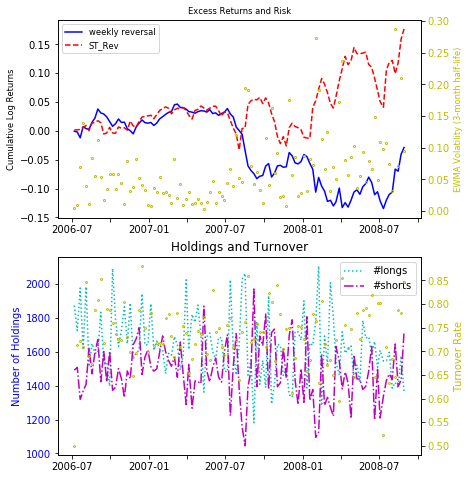

In [4]:
    benchnames = ['ST_Rev']
    backtest.performance(crsp, holdings, label=('weekly reversal'))
    print(backtest.attribution(benchnames, flip=False))
    backtest.plot(benchnames)
    pprint(backtest.annualized)

### Generate HML signal
- allow 6 months after fiscal end for data to become available for portfolio rebalances
- december fiscal year ends and price (for market cap)

In [35]:
    crsp.rdb = rdb   # reaffirm use redis cache                                                              
    rebalbeg, rebalend = 19500601, 20190630
    beg, end = crsp.dates.begmo(rebalbeg, -6), crsp.dates.endmo(rebalend, -6)

    # retrieve required fields from database                                                                 
    df = pstat.get_linked(table = 'annual', date_field = 'datadate',
                          fields = ['ceq','pstk'],  # 'pstkrv', 'pstkl',                                     
                          where = ("ceq > 0 and datadate >= {beg} and datadate <= {end}" \
                                   "".format(beg=beg, end=end)))
    # construct book values                                                                                  
    df['hml'] = 0
    df.loc[df['pstk'].gt(0),   'hml'] = -df.loc[df['pstk'].gt(0),   'pstk']
#    df.loc[df['pstkl'].gt(0),  'hml'] = -df.loc[df['pstkl'].gt(0),  'pstkl']                                
#    df.loc[df['pstkrv'].gt(0), 'hml'] = -df.loc[df['pstkrv'].gt(0), 'pstkrv']                               
    df['hml'] += df['ceq']
    df['rebaldate'] = 0

    # construct b/m ratio                                                                                    
    for datadate in sorted(df['datadate'].unique()):
        f = df['datadate'].eq(datadate)
        rebaldate = crsp.dates.endmo(datadate, 6)        # rebalance date >= 6 months after fiscal end       
        pricedate = bd._months.loc[((rebaldate-10000)//10000, 12), 'endmo']      # december market cap       
        permnos = list(df.loc[f, 'permno'])
        df.loc[f, 'rebaldate'] = rebaldate
        df.loc[f, 'cap'] = (crsp.get_cap(pricedate).reindex(permnos)).values
    df['hml'] /= df['cap']
    print('{} dates {}-{}: {} records'.format(
        len(df['rebaldate'].unique()), min(df['rebaldate']), max(df['rebaldate']), len(df)))


684 dates 19600630-20190628: 259131 records


### Compare to French data library -- highly correlated but some differences remain
Note: in all backtest attribution output, welch test is for different of mean returns before and after 2002.

(portfolio_sorts)  False
                            OLS Regression Results                            
Dep. Variable:                    hml   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     1164.
Date:                Fri, 31 Jan 2020   Prob (F-statistic):          1.30e-149
Time:                        13:04:39   Log-Likelihood:                 1835.9
No. Observations:                 684   AIC:                            -3668.
Df Residuals:                     682   BIC:                            -3659.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
alpha          0.0011      

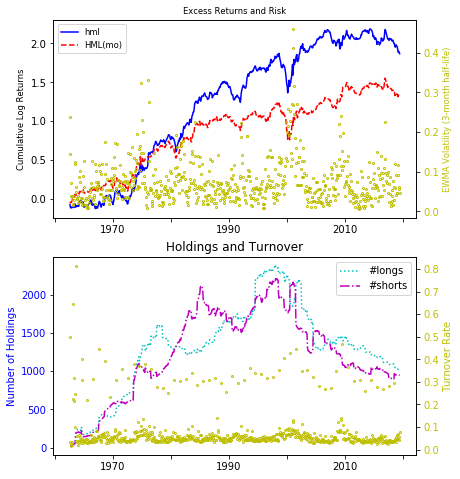

In [36]:
    benchnames = ['HML(mo)']
    signal = 'hml'
    holdings = crsp.portfolio_sorts(signal, data = df, beg = rebalbeg, end = rebalend,
                                    window = 12,     # use latest signal from recent 12 months rebalances    
                                    month = 6)       # determine universe of stocks every June               
    backtest.performance(crsp, holdings, label = signal)
    backtest.attribution(benchnames, flip=False)     # do not flip returns (not a reversal strategy)         
    backtest.plot(benchnames)
    print(backtest.results.summary())
    pprint(backtest.annualized)

### comment

### comment

### comment

### comment

### comment

### comment

### comment